In [1]:
import pandas as pd
from preprocessing import *
from models import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler 
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

2023-11-08 19:32:37.676713: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-08 19:32:38.290309: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-08 19:32:38.290387: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-08 19:32:38.295841: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-08 19:32:38.642667: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-08 19:32:38.644462: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
def preprocess_load(path, skips, col):
    df = load_network_csv(path)
    df = downsample_df(df, skips)
    return df[col]

In [3]:
def preprocess_split(df, split: 0):
    train_df, test_df, _, _ = time_split(df, split)
    return train_df, test_df

In [4]:
def preprocess_to_numpy(df, col):
    return df[col].to_numpy()

In [5]:
def create_X_y(df, time_steps: 10):
    X, y = [], []
    for i in range(len(df) - time_steps):
        v = df[i:(i + time_steps)]
        X.append(v)
        y.append(df[i + time_steps])
    return np.array(X), np.array(y)

In [6]:
time_steps = 10
scaler = MinMaxScaler()
path = ["dataset/Network datatset/csv/normal.csv"]
skips = 50
col = 'size'
cols = ['Time', 'label', col]
split = 0.2

df = preprocess_load(path, skips, cols)
train_df, test_df = preprocess_split(df, split)
train, test = preprocess_to_numpy(train_df, col), preprocess_to_numpy(test_df, col)
print(train.shape, test.shape)
train = scaler.fit_transform(train.reshape(-1, 1))
test = scaler.transform(test.reshape(-1, 1))
print(train.shape, test.shape)
X_train, y_train = create_X_y(train, time_steps)
X_test, y_test = create_X_y(test, time_steps)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(124116,) (31030,)
(124116, 1) (31030, 1)


((124106, 10, 1), (124106, 1), (31020, 10, 1), (31020, 1))

In [7]:
def get_model(X_train):
    model= keras.Sequential()
    model.add(keras.layers.LSTM(units=128,input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(keras.layers.Dropout(rate=0.2))

    model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
    model.add(keras.layers.LSTM(units=128,return_sequences=True))

    model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))

    model.compile(loss='mae',optimizer ='adam')
    return model


In [8]:
model = get_model(X_train)
model.summary()

2023-11-08 19:33:14.184895: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-08 19:33:14.514806: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 repeat_vector (RepeatVecto  (None, 10, 128)           0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 10, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 10, 128)           0         
                                                                 
 time_distributed (TimeDist  (None, 10, 1)             129       
 ributed)                                               

In [9]:
history = model.fit(X_train, y_train, epochs=25, batch_size=64, validation_split=0.1, shuffle=False)

Epoch 1/25
1746/1746 [==============================] - 48s 25ms/step - loss: 0.0494 - val_loss: 0.0488
Epoch 2/25
1746/1746 [==============================] - 42s 24ms/step - loss: 0.0477 - val_loss: 0.0484
Epoch 3/25
1746/1746 [==============================] - 41s 24ms/step - loss: 0.0474 - val_loss: 0.0484
Epoch 4/25
1746/1746 [==============================] - 46s 27ms/step - loss: 0.0473 - val_loss: 0.0482
Epoch 5/25
1746/1746 [==============================] - 45s 26ms/step - loss: 0.0466 - val_loss: 0.0462
Epoch 6/25
1746/1746 [==============================] - 47s 27ms/step - loss: 0.0432 - val_loss: 0.0423
Epoch 7/25
1746/1746 [==============================] - 46s 26ms/step - loss: 0.0416 - val_loss: 0.0419
Epoch 8/25
1746/1746 [==============================] - 43s 25ms/step - loss: 0.0410 - val_loss: 0.0416
Epoch 9/25
1746/1746 [==============================] - 44s 25ms/step - loss: 0.0407 - val_loss: 0.0416
Epoch 10/25
1746/1746 [==============================] - 46s 26m

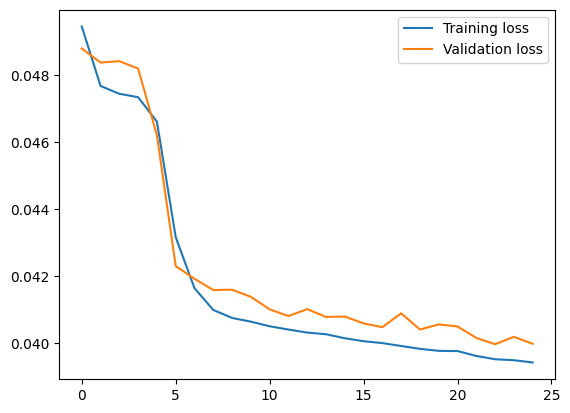

In [10]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend();

In [11]:
model.evaluate(X_test, y_test)

  1/970 [..............................] - ETA: 48s - loss: 0.0331

970/970 [==============================] - 7s 7ms/step - loss: 0.0395


0.03952790051698685

Reconstruction error threshold: 0.2278973784711626


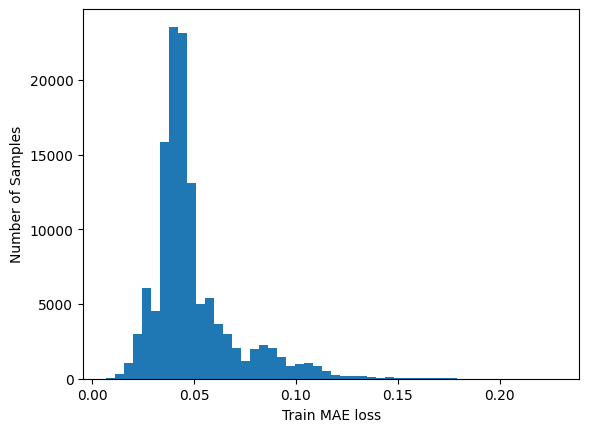

In [12]:
X_train_pred = model.predict(X_train, verbose=0)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples')

threshold = np.max(train_mae_loss)
print(f'Reconstruction error threshold: {threshold}')

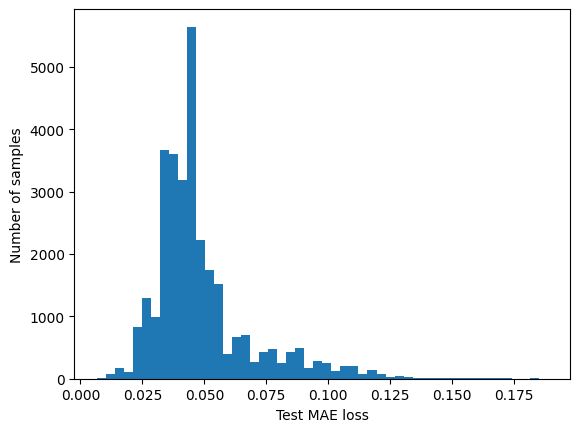

In [13]:
X_test_pred = model.predict(X_test, verbose=0)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples');

In [14]:
import plotly.graph_objects as go

In [15]:
test_score_df = pd.DataFrame(test_df[time_steps:])
print(test_score_df.shape)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
test_score_df['Time'] = test_df[time_steps:]['Time']

fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df['Time'], y=test_score_df['loss'], name='Test loss'))
fig.add_trace(go.Scatter(x=test_score_df['Time'], y=test_score_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

(31020, 2)


## Test on attack data

In [16]:
def detect_anomalies(path, time_steps, skips, col: str, scaler):
    attacks_df = preprocess_load([path], skips, ['Time', 'label', col])
    print(f"Attacks shape: {attacks_df.columns}")
    print(f"Number of attacks: {(attacks_df['label'] != 'normal').sum()}")
    
    attacks = preprocess_to_numpy(attacks_df, col)
    attacks = scaler.transform(attacks.reshape(-1, 1))
    print(f"Attacks shape: {attacks.shape}")
    X, y = create_X_y(attacks, time_steps)
    
    X_pred = model.predict(X, verbose=1)
    
    mae_loss = np.mean(np.abs(X_pred - X), axis=1)
    print(f"MAE loss shape: {mae_loss.shape}")
    
    anomalies = mae_loss > threshold
    print(f"Number of anomalies: {anomalies.sum()}")
    
    #Check if is it a false positive
    without_index = (attacks_df[time_steps:]['label'] == 'normal').to_numpy()
    false_positives = 0
    true_positives = 0
    for i in range(len(anomalies)):
        if anomalies[i] and without_index[i]:
            false_positives += 1
        elif anomalies[i] and not without_index[i]:
            true_positives += 1
    print(f"Number of false positives: {false_positives}")
    print(f"Number of true positives: {true_positives}")
    return mae_loss, anomalies

In [17]:
mae_loss, anomalies = detect_anomalies("dataset/Network datatset/csv/attack_1.csv", time_steps, skips, col, scaler)

Attacks shape: Index(['Time', 'label', 'size'], dtype='object')
Number of attacks: 24282
Attacks shape: (98031, 1)
3064/3064 [==============================] - 22s 7ms/step
MAE loss shape: (98021, 1)
Number of anomalies: 0
Number of false positives: 0
Number of true positives: 0


Text(0, 0.5, 'Number of samples')

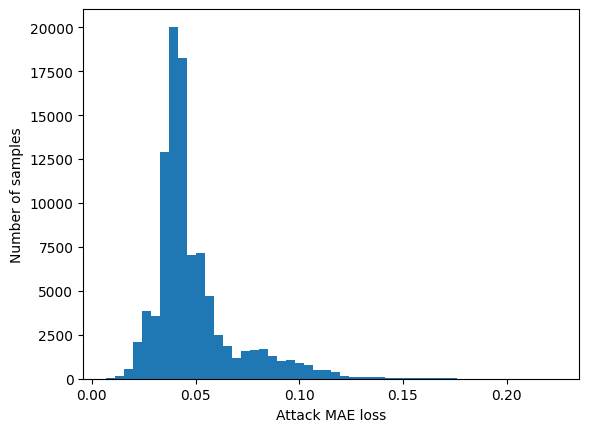

In [18]:
plt.hist(mae_loss, bins=50)
plt.xlabel('Attack MAE loss')
plt.ylabel('Number of samples')